<a href="https://colab.research.google.com/github/Xmen3em/Beginner-Projects/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview of Dataset
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

The dataset consists about 28000 text data points where each data category belongs to 2 category - Sarcastic or Not Sarcastic

We will use two models for making predictions - Word2Vec and GloVe Embeddings. We will then compare their results and see which performs better

## Import important libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")
import os
from tensorflow.keras import layers
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from bs4 import BeautifulSoup

## Get the Data


In [10]:
data = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json",lines = True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [11]:
data.shape

(28619, 3)

In [12]:
data.isna().sum()

,0
is_sarcastic,0
headline,0
article_link,0


In [13]:
data.duplicated().sum()

2

In [14]:
del data['article_link']

## Data Visualization

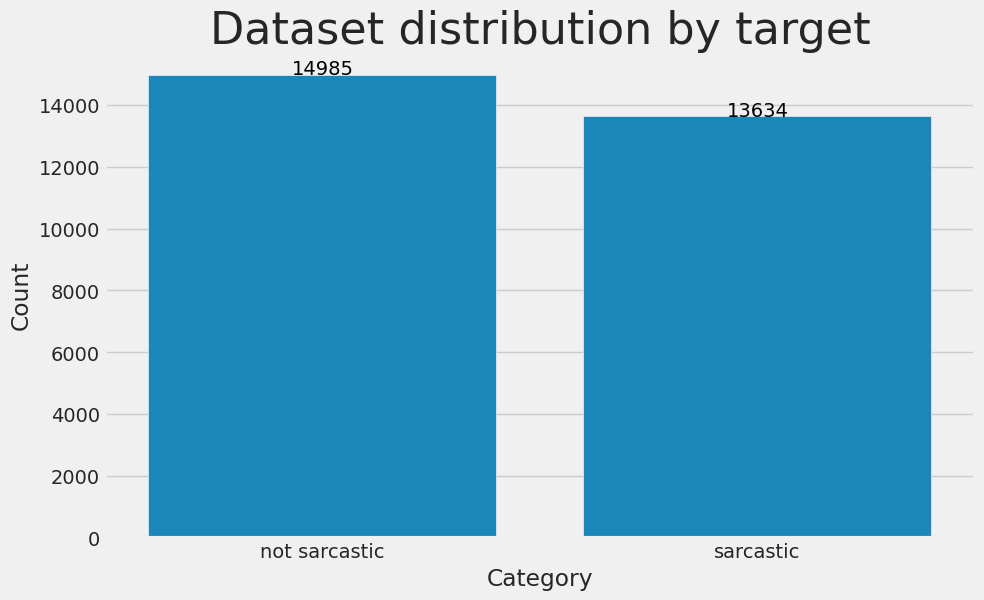

In [15]:
balance_counts = data.groupby('is_sarcastic')['is_sarcastic'].agg('count').values

data_1 = {
    'Category': ['not sarcastic', 'sarcastic'],
    'Count': [balance_counts[0], balance_counts[1]]
}

df = pd.DataFrame(data_1)

plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Category', y = 'Count', data = df)

for index, row in df.iterrows():
    barplot.text(index, row.Count, row.Count, color = 'black', ha = "center")

plt.title('Dataset distribution by target', fontsize = 32, fontname = 'Times New Roman')
plt.show()

In [16]:
data['len_headline'] = data.headline.apply(len)
data.head()

,is_sarcastic,headline,len_headline
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep. totally nails why congress is falling...,79
2,0,eat your veggies: 9 deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word 'strea...,61


Text(0.5, 0, 'Headline Length')

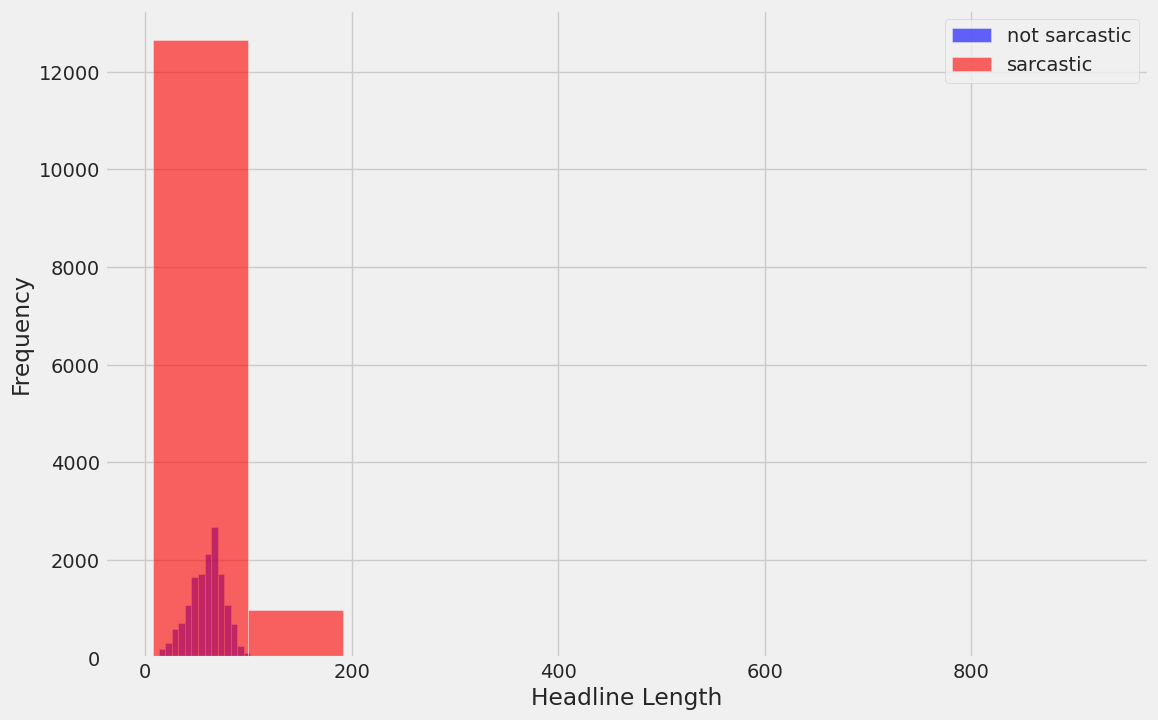

In [17]:
plt.figure(figsize=(12, 8))

data[data.is_sarcastic ==0].len_headline.plot(bins = 35,
                                                            kind = 'hist',
                                                            color = 'blue',
                                       label = 'not sarcastic', alpha = 0.6)
data[data.is_sarcastic == 1].len_headline.plot(kind = 'hist',
                                                             color = 'red',
                                       label = 'sarcastic', alpha = 0.6)
plt.legend()
plt.xlabel("Headline Length")

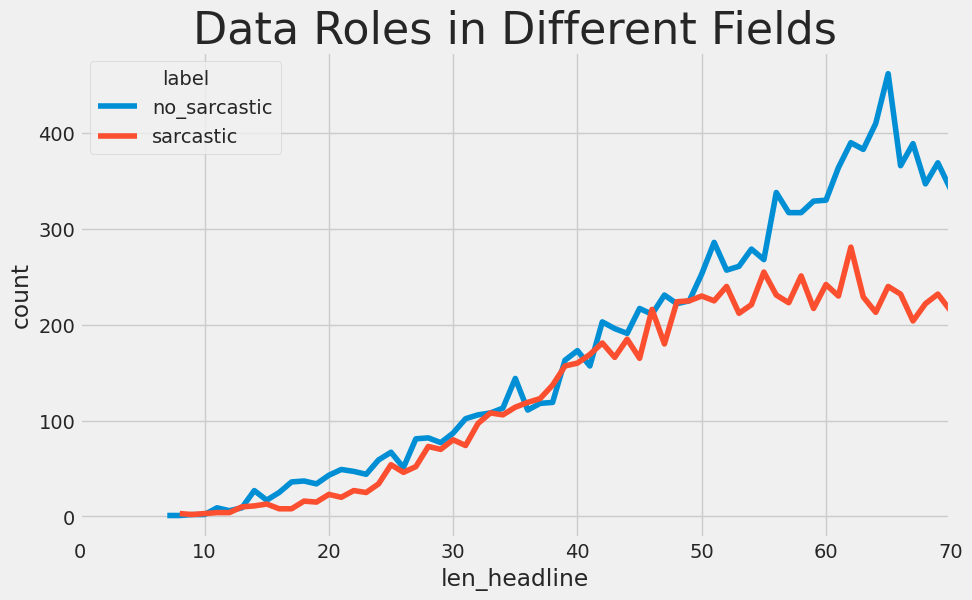

In [18]:
no_sarcastic = data[data['is_sarcastic'] == 0]['len_headline'].value_counts().sort_index()
sarcastic = data[data['is_sarcastic'] == 1]['len_headline'].value_counts().sort_index()

no_sarcastic_data = pd.DataFrame({'len_headline': no_sarcastic.index, 'count': no_sarcastic.values, 'label': 'no_sarcastic'})
sarcastic_data = pd.DataFrame({'len_headline': sarcastic.index, 'count': sarcastic.values, 'label': 'sarcastic'})

combined_df = pd.concat([no_sarcastic_data, sarcastic_data])

plt.figure(figsize = (10, 6))
sns.lineplot(data = combined_df, x = 'len_headline', y = 'count', hue = 'label')

plt.title('Data Roles in Different Fields', fontsize = 32, fontname = 'Times New Roman')
plt.xlim(0, 70)
plt.show()

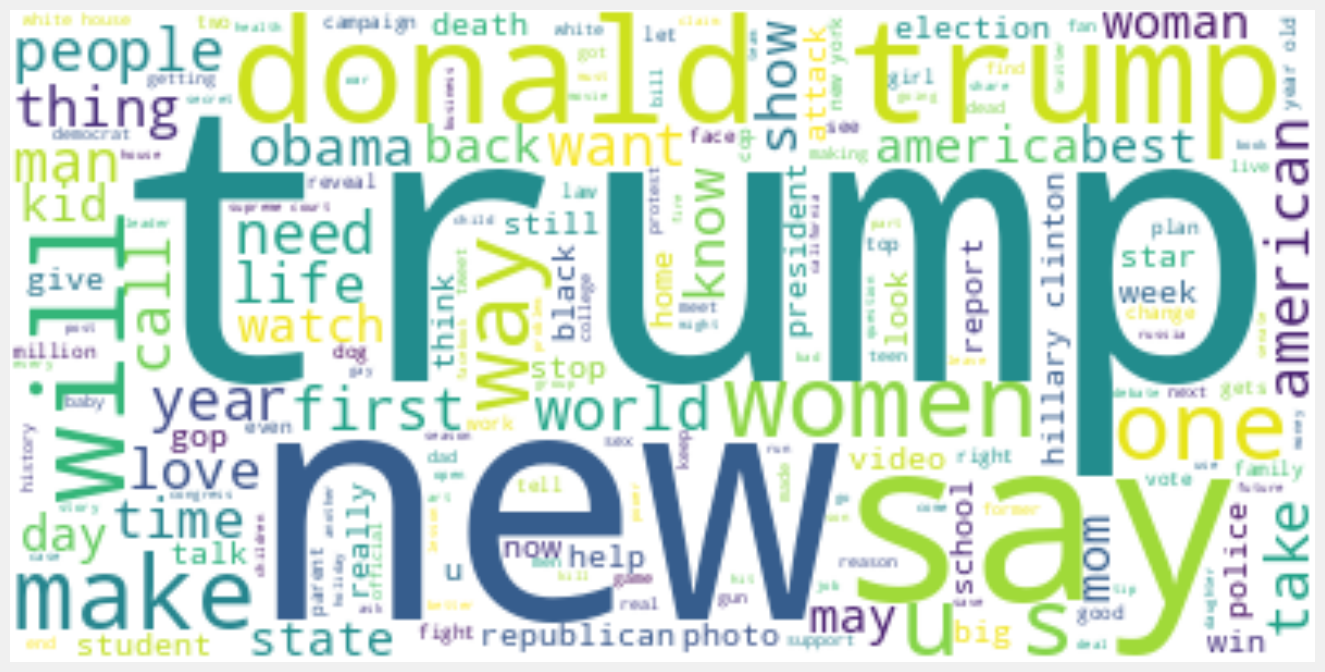

In [19]:
# WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC
from wordcloud import WordCloud

text = " ".join(review for review in data[data['is_sarcastic'] == 0]['headline'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

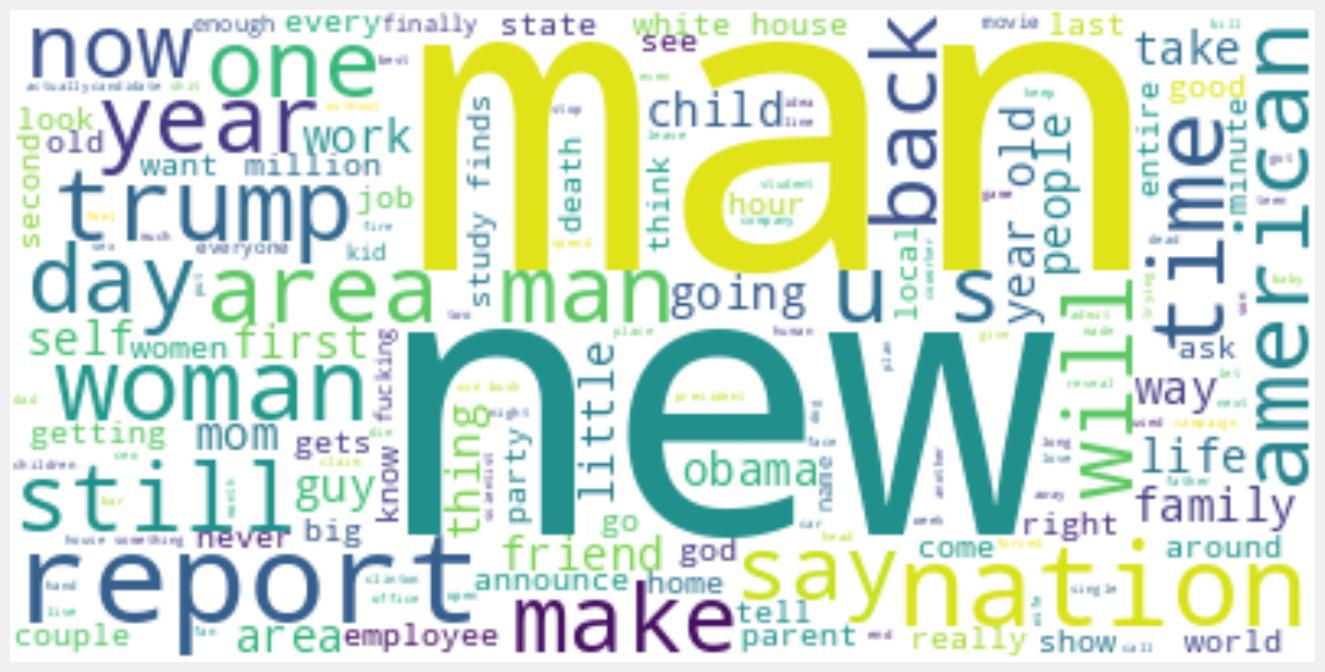

In [20]:
# WORDCLOUD FOR TEXT THAT IS SARCASTIC
text = " ".join(review for review in data[data['is_sarcastic'] == 1]['headline'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Convert data to tf.data.Dataset


In [156]:
def train_val_datasets(data):

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = data.shape[0]

    # Slice the dataset to get only the texts. Remember that texts are on the second column
    texts = data['headline']
    # Slice the dataset to get only the labels. Remember that labels are on the first column
    labels = data['is_sarcastic']

    split_index = int(len(texts) * 0.8)

    # Split the data into training and validation sets
    train_texts = texts[:split_index]
    validation_texts = texts[split_index:]


    train_labels = labels[:split_index]
    validation_labels = labels[split_index:]

    # create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    text_train_data = [text.numpy().decode('utf-8') for text, label in train_dataset]
    label_train_data = [label.numpy() for text, label in train_dataset]

    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))
    text_validation_data = [text.numpy().decode('utf-8') for text, label in validation_dataset]
    label_validation_data = [label.numpy() for text, label in validation_dataset]

    return np.array(text_train_data), np.array(label_train_data), np.array(text_validation_data), np.array(label_validation_data)

In [157]:
text_train_data, label_train_data, text_validation_data, label_validation_data = train_val_datasets(data)
text_train_data.shape, label_train_data.shape, text_validation_data.shape, label_validation_data.shape

((22895,), (22895,), (5724,), (5724,))

## Data Preprocessing

In [158]:
def standardize_func(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")

    # strip html
    sentence = tf.strings.regex_replace(sentence, r"<br />", " ")
    sentence = tf.strings.regex_replace(sentence, r"<br/>", " ")

    # removing square brackets
    sentence = tf.strings.regex_replace(sentence, r"\[", "")
    sentence = tf.strings.regex_replace(sentence, r"\]", "")

    # removing urls
    sentence = tf.strings.regex_replace(sentence, r"http\S+", "")
    sentence = tf.strings.regex_replace(sentence, r"www\S+", "")

    # removing numbers
    sentence = tf.strings.regex_replace(sentence, r"\d", "")

    return sentence

In [159]:
test_sentence = "Hello! We're just about to see this function in action =)"
standardized_sentence = standardize_func(test_sentence)
print(f"Original sentence is:\n{test_sentence}\n\nAfter standardizing:\n{standardized_sentence}")

Original sentence is:
Hello! We're just about to see this function in action =)

After standardizing:
b'hello  just   see  function  action '


In [160]:
def fit_vectorizer(train_sentences, standardize_func):

    # Instantiate the TextVectorization class, passing in the correct values for the given parameters below
    vectorizer = tf.keras.layers.TextVectorization(
		standardize = standardize_func,
     max_tokens = 35000,
		output_sequence_length = 20
	)

    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)

    return vectorizer

In [162]:
vectorizer = fit_vectorizer(text_train_data, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 24928 words



## Modeling

In [169]:
def create_model():

    # Define your model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=[1,], dtype = tf.string),
        vectorizer,
        tf.keras.layers.Embedding(vocab_size, 200, input_length = 20),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    # Compile model. Set an appropriate loss, optimizer and metrics
    model.compile(
		loss = tf.keras.losses.binary_crossentropy,
		optimizer = 'adam',
		metrics = ['accuracy']
	)

    return model

In [170]:
model = create_model()
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_4                 │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_24 (Embedding)             │ (None, 20, 200)             │       4,985,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_24          │ (None, 200)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,985,801 (19.02 MB)

 Trainable params: 4,985,801 (19.02 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# convert text train and val to tf.string
text_train_data = tf.convert_to_tensor(text_train_data, dtype=tf.string)
text_validation_data = tf.convert_to_tensor(text_validation_data, dtype=tf.string)

In [172]:
tf.random.set_seed(42)
history = model.fit(text_train_data, label_train_data, epochs = 30, validation_data = (text_validation_data, label_validation_data))

Epoch 1/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6104 - loss: 0.6456 - val_accuracy: 0.7909 - val_loss: 0.4654
Epoch 2/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8374 - loss: 0.3868 - val_accuracy: 0.8061 - val_loss: 0.4178
Epoch 3/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8973 - loss: 0.2633 - val_accuracy: 0.8104 - val_loss: 0.4288
Epoch 4/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9267 - loss: 0.1933 - val_accuracy: 0.8115 - val_loss: 0.4683
Epoch 5/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9474 - loss: 0.1473 - val_accuracy: 0.8038 - val_loss: 0.5391
Epoch 6/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9602 - loss: 0.1157 - val_accuracy: 0.7939 - val_loss: 0.6193
Epoch 7/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9697 - loss: 0.0930 - val_accuracy: 0.7937 - val_loss: 0.6715
Epoch 8/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9759 - loss: 0.0753 - val_accurac

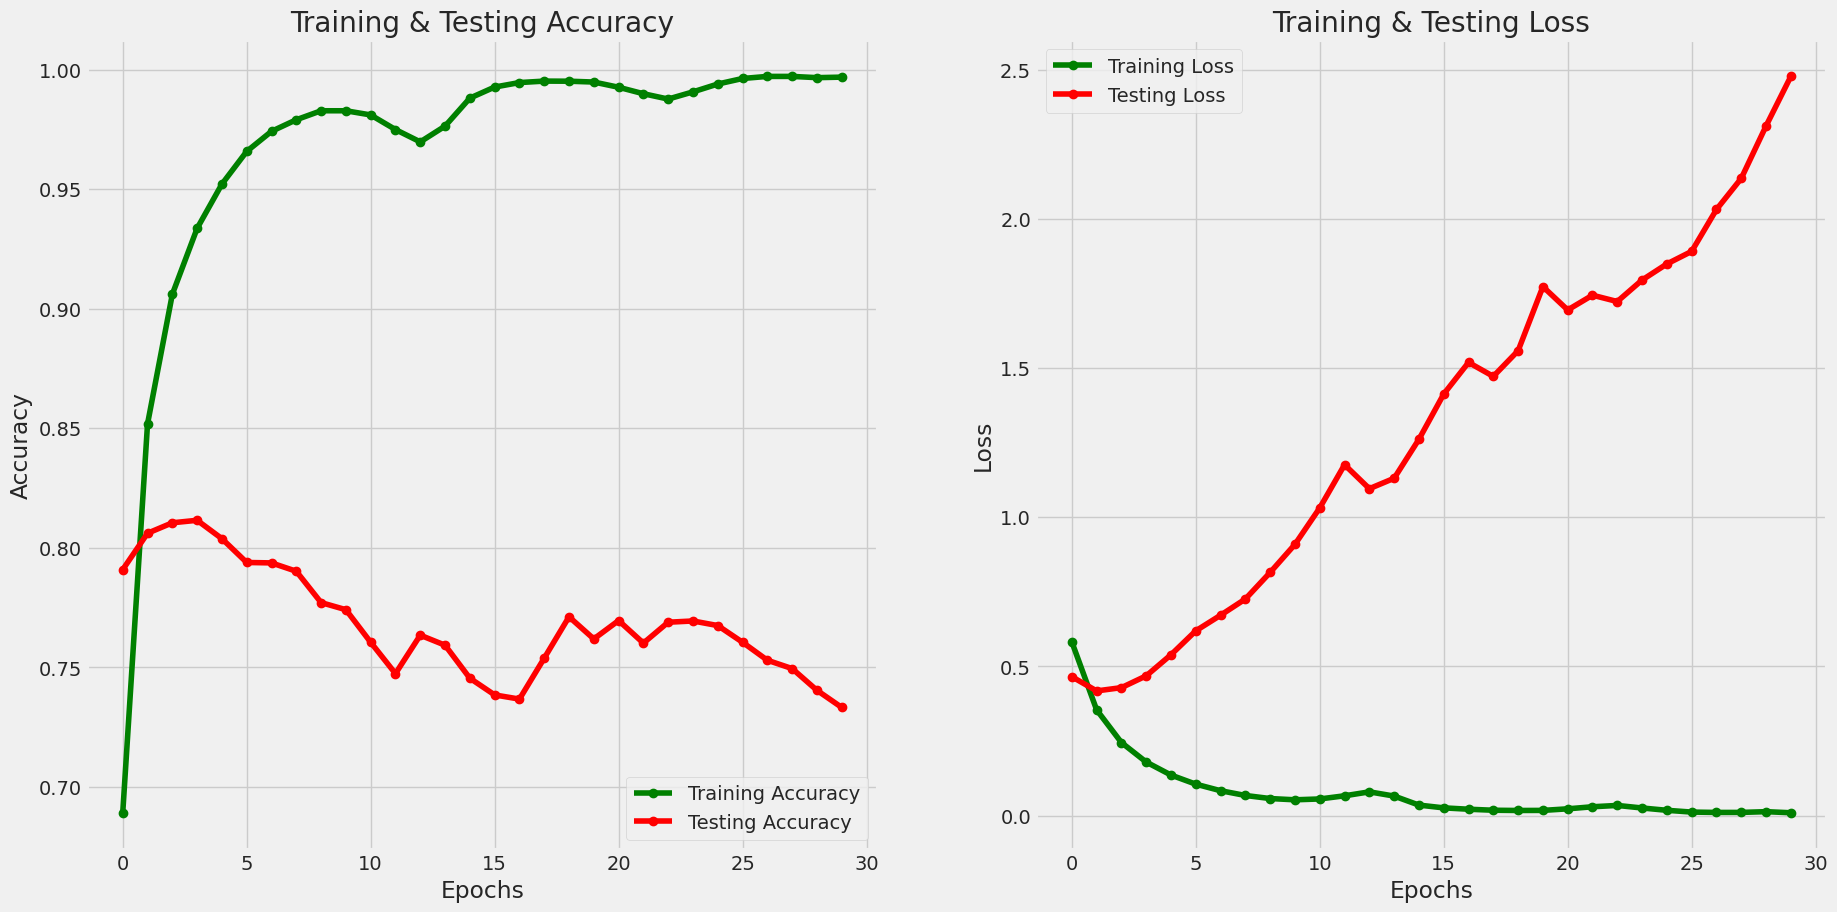

In [173]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Try using Glove Embeddings

In [174]:
# helper function
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# glove embedding
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

# unzip folder
from helper_functions import unzip_data
unzip_data('glove.twitter.27B.zip')

--2024-10-10 11:42:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-10 11:42:53 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2024-10-10 11:42:54--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2024-10-10 11:42:54--  https://

In [206]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['headline'], data['is_sarcastic'], test_size=0.2, random_state=42)
X_train.shape

(22895,)

In [207]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts()
word2index = tokenizer.word_index

In [208]:
len(word2index)

27769

In [209]:
max_len = round(sum([len(i.split()) for i in X_train]) / len(X_train))
max_len

10

In [210]:
file = open('glove.twitter.27B.200d.txt', 'r', encoding = 'utf8')
content = file.readlines()
file.close()

embeddings = {}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

embed_size = 200
embedding_matrix = np.zeros((len(word2index)+1, embed_size))

for word, i in word2index.items():
    embed_vector = embeddings.get(word) # Use get() to avoid KeyError
    if embed_vector is not None:
        embedding_matrix[i] = embed_vector
    else:
        embedding_matrix[i] = np.random.randn(embed_size) # Replace OOV with random vector

In [212]:
from tensorflow.keras.layers import Embedding
embedding_1 = Embedding(
        input_dim = len(word2index) + 1,
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = max_len
    )

In [216]:
model_1 = tf.keras.Sequential([
    layers.Input(shape = (1,), dtype = tf.string),
    vectorizer,
    embedding_1,
    layers.Bidirectional(layers.LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3, return_sequences = True)),
    layers.Bidirectional(layers.GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)),
    layers.Dropout(0.5),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
], name = 'model_1_dense')

model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_4                 │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_26 (Embedding)             │ (None, 20, 200)             │       5,554,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 20, 256)             │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │          55,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,963,217 (22.75 MB)

 Trainable params: 5,963,217 (22.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.random.set_seed(42)
history_1 = model_1.fit(text_train_data, label_train_data, epochs = 30,
                        validation_data = (text_validation_data, label_validation_data))

Epoch 1/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 162s 206ms/step - accuracy: 0.6171 - loss: 0.6309 - val_accuracy: 0.7787 - val_loss: 0.4590
Epoch 2/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 198s 206ms/step - accuracy: 0.8120 - loss: 0.4094 - val_accuracy: 0.8050 - val_loss: 0.4255
Epoch 3/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 145s 202ms/step - accuracy: 0.8854 - loss: 0.2788 - val_accuracy: 0.8127 - val_loss: 0.4798
Epoch 4/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 141s 196ms/step - accuracy: 0.9308 - loss: 0.1860 - val_accuracy: 0.8087 - val_loss: 0.5652
Epoch 5/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.9511 - loss: 0.1381 - val_accuracy: 0.7998 - val_loss: 0.6384
Epoch 6/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.9629 - loss: 0.0949 - val_accuracy: 0.8005 - val_loss: 0.7189
Epoch 7/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - accuracy: 0.9731 - loss: 0.0719 - val_accuracy: 0.7982 - val_loss: 0.8152
Epoch 8/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - accuracy: 0.9813 -